# Проверка гипотез по увеличению выручки в интернет-магазине ⏤ оценить результаты A/B-теста ⚖️

## Содержание
1) [Описание проекта](#anchor_1)  
2) [Загрузка данных и подготовка их к анализу](#anchor_2)  
3) [Приоретизация гипотез](#anchor_3)  
4) [Анализ кумулятивных метрик](#anchor_4)  
5) [Анализ выбросов и всплесков](#anchor_5)  
6) [Анализ А/В-теста](#anchor_6)  
    - [Статистическая значимость различий в конверсии между группами по «сырым» данным](#anchor_7)  
    - [Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным](#anchor_8)  
    - [Статистическая значимость различий в конверсии между группами по «очищенным» данным](#anchor_9)  
    - [Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным](#anchor_10)      
7) [Общий вывод по исследованию](#anchor_11)  

 <a id='anchor_1'></a>
 ## Описание проекта 

В нашем распоряжении данные о продажах крупного интернет-магазина. Вместе с отделом маркетинга был подготовлен список гипотез для увеличения выручки. Наша задача - приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты.

**Цель исследования:**

Определить иерархию приоретета гипотез по увеличению выручки. Принять решение по результатам A/B-теста (остановить, зафиксировав преимущество одной из групп или отсутсвие значимых различий между ними; продолжить тест).

**Ход исследования:**

Часть 1. Приоритизация гипотез.
Необходимо изучить список гипотез по увеличению выручки интернет-магазина, приоритизировать их (используя фреймворки ICE и RICE). Сравним  иерархии приоритета гипотез, сделаем выводы о причинах полученных изменений.  

Часть 2. Анализ A/B-теста
Прочитаем из файлов данные о полученных результатах A/B-теста.
Исследуем результаты проведенного А/В-теста. Сначала построим графики кумулятивной выручки, среднего чека и конверсии, а также их относительного изменения, сравним результаты по группам и сделаем выводы. Изучим данные на предмет выбросов, найдём границы для их отсечения. Определим статистическую значимость различий исследуемых метрик по «сырым» и по «очищенным» данным. Сравним результаты теста и примем решение по результатам теста, объясним его. Варианты решений: 
    
1. Остановить тест, зафиксировав победу одной из групп. 
2. Остановить тест, зафиксировав отсутствие различий между группами. 
3. Продолжить тест.

 <a id='anchor_2'></a>
 ## Загрузка данных и подготовка их к анализу

Для начала произведём импорт всех необходимых нам библиотек и сделаем некоторые настройки:

In [1]:
# импорт библиотеки pandas
import pandas as pd

#импорт библиотеки numpy для операций с массивами
import numpy as np

# импорт библиотеки визуализации seaborn
import seaborn as sns

# импорт библиотеки matplotlib для продвинутой работы с графиками
import matplotlib.pyplot as plt

# импорт библиотек для проведения статистических тестов
from scipy import stats as st
import scipy.stats as stats

# импорт библиотеки для работы с датами
import datetime as dt

# снимем ограничение по ширине граф
pd.set_option('display.max_colwidth', None)

# зафиксируем размер графиков
plt.rcParams["figure.figsize"] = (12,5)

Прочитаем данные из файла с информацией о гипотезах по увеличению выручки интернет-магазина. Выведем на экран датасет:

In [2]:
try:
    hyp = pd.read_csv('/datasets/hypothesis.csv')
except:
    hyp = pd.read_csv('hypothesis.csv')
display(hyp)

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Согласно документации к данным таблица hypothesis содержит следующую информацию:

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале (чем больше значение Efforts, тем дороже проверка гипотезы).

Сразу можно заметить в названиях столбцов нарушение хорошего стиля. Исправим это, приведя их к нижнему регистру:

In [3]:
hyp.columns = hyp.columns.str.lower()
hyp.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

Посмотрим главные характеристики таблицы, воспользовавшись методом info():

In [4]:
hyp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


В таблице не содержится пропусков и/или дубликатов, нет проблем также и с типами данных. Таким образом, можно перейти к изучению информации в следующем файле (информация о заказах):

In [5]:
try:
    orders = pd.read_csv('/datasets/orders.csv')
except:
    orders = pd.read_csv('orders.csv')
display(orders.head())

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Согласно документации к данным таблица orders (информация о заказах, результат проведения А/В-теста):

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Исправим нарушение хорошего стиля в заголовках:

In [6]:
orders = orders.rename(columns = {'transactionId':'transaction_id', 'visitorId':'visitor_id'})
orders.columns

Index(['transaction_id', 'visitor_id', 'date', 'revenue', 'group'], dtype='object')

Посмотрим главные характеристики таблицы, воспользовавшись методом *info()*:

In [7]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   transaction_id  1197 non-null   int64 
 1   visitor_id      1197 non-null   int64 
 2   date            1197 non-null   object
 3   revenue         1197 non-null   int64 
 4   group           1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


Таблица не содержит пропусков (в силу небольшого количества граф это сразу видно, нет необходимости проверять и рассчитывать долю пропущенных значений методом isna()). Проверим, имеются ли в ней дубликаты:

In [8]:
orders.duplicated().sum()

0

Дубликатов тоже не оказалось. Для удобной работы с датами приведём данные графы 'date' к типу datetime:

In [9]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
orders.dtypes

transaction_id             int64
visitor_id                 int64
date              datetime64[ns]
revenue                    int64
group                     object
dtype: object

Выведем максимальную и минимальную дату, таким образом, узнаем период проведения А/В-теста, описанный в файле:

In [10]:
print(orders['date'].max())
print(orders['date'].min())

2019-08-31 00:00:00
2019-08-01 00:00:00


Получаем, что А/В-тест проводился на протяжении месяца. 

Посмотрим уникальные значения в столбце 'group', чтобы убедиться, что там не содержатся неявные дубликаты или некорректные значения:

In [11]:
orders['group'].unique()

array(['B', 'A'], dtype=object)

Неявных дубликатов тоже не оказалось. Изучим информацию в последнем файле, сохраним её в переменной:

In [12]:
try:
    visitors = pd.read_csv('/datasets/visitors.csv')
except:
    visitors = pd.read_csv('visitors.csv')
display(visitors.head())

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Согласно документации к данным таблица visitors  (информация о пользователях, результат проведения А/В-теста):

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста.

Посмотрим главные характеристики таблицы, воспользовавшись методом *info()*:

In [13]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Пропусков нет, убедимся в отсутствии дубликатов:

In [14]:
visitors.duplicated().sum()

0

Посмотрим уникальные значения в столбце 'group', чтобы убедиться, что там не содержатся неявные дубликаты или некорректные значения:

In [15]:
visitors['group'].unique()

array(['A', 'B'], dtype=object)

Подозрительных значений не оказалось. Для удобной работы с датами приведём данные графы 'date' к типу datetime:

In [16]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)
visitors.dtypes

date        datetime64[ns]
group               object
visitors             int64
dtype: object

Выведем максимальную и минимальную дату. Убедимся, что период проведения А/В-теста в двух таблицах совпадает:

In [17]:
print(visitors['date'].max())
print(visitors['date'].min())

2019-08-31 00:00:00
2019-08-01 00:00:00


Важным условием успешности проведения А/В-теста является отсутствие в группах пересекающихся значений. Проверим это для нашего случая:

In [18]:
print('Количество уникальных пользователей в обеих группах:', len( orders['visitor_id'].unique()))
# составим списки уникальных пользователей для каждой группы
group_a = orders.query('group == "A"')['visitor_id'].unique()
group_b = orders.query('group == "B"')['visitor_id'].unique()
# выделим пересекающиеся значения в отдельный список
a_cross_b = np.intersect1d(group_b, group_a)
print(a_cross_b)
print('Количество пересекающихся значений в группах:', len(a_cross_b))

Количество уникальных пользователей в обеих группах: 1031
[   8300375  199603092  232979603  237748145  276558944  351125977
  393266494  457167155  471551937  477780734  818047933  963407295
 1230306981 1294878855 1316129916 1333886533 1404934699 1602967004
 1614305549 1648269707 1668030113 1738359350 1801183820 1959144690
 2038680547 2044997962 2378935119 2458001652 2579882178 2587333274
 2600415354 2654030115 2686716486 2712142231 2716752286 2780786433
 2927087541 2949041841 2954449915 3062433592 3202540741 3234906277
 3656415546 3717692402 3766097110 3803269165 3891541246 3941795274
 3951559397 3957174400 3963646447 3972127743 3984495233 4069496402
 4120364173 4186807279 4256040402 4266935830]
Количество пересекающихся значений в группах: 58


Удалим данные о пользователях, которые попали в обе группы, они могут исказить результаты А/В-теста:

In [19]:
orders = orders.query('visitor_id not in @a_cross_b')
print('Количество уникальных пользователей в очищенных от пересечений группах:', len( orders['visitor_id'].unique()))

Количество уникальных пользователей в очищенных от пересечений группах: 973


Таким образом, мы удалили данные о пересекающихся пользователях, чтобы улучшить качество результатов проведенного А/В-теста.

Итак, на первом этапе исследования мы изучили исходные данные, убедились в отсутствии пропусков и дубликатов. Проверили данные на наличие неявных дубликатов, которых в нашем массиве не оказалось. Устранили нарушение хорошего стиля в названиях граф, а также привели тип данных к более подходящему для работы (в частности, информацию о датах). Так как важдым условием успешности проведения А/В-теста является отсутствие в группах пересекающихся значений, мы проверили данные на предмет пересечений. Нашли 58 таких пользователей и удалили их.  
Закончив с предобработкой данных, можно переходить к следующим шагам исследования.

 <a id='anchor_3'></a>
 ## Приоретизация гипотез

Проверка гипотез чаще всего стоит дорого, а в ресурсах мы обычно ограничены. Таким образом, приходится делать выбор в пользу одних гипотез, отказываясь или откладывая при этом другие. Чтобы максимизировать ожидаемое улучшение ключевых метрик бизнеса, сформулированные гипотезы приоритизируют.

В нашем распоряжении есть 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort.
Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета. Для расчета испольуем следующую формулу:

$$ICE = \frac{Impact * Confidence}{Effort}$$ 

In [20]:
hyp['ICE'] = round(hyp['impact']*hyp['confidence']/hyp['efforts'])
display(hyp[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.0
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.0
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.0


Оценив приоритет гипотез методом ICE, мы можем выделить три наиболее перспективные (восьмая, нулевая и седьмая):

- Запустить акцию, дающую скидку на товар в день рождения;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей;
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок.

Данные гипотезы при наименьших затратах ресурсов на их проверку окажут наибольшее влияние на пользователей при наибольшей уверенности в этих гипотезах. Однако, метод ICE не учитывает охват пользователей при упорядочивании экспериментов.

Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета. Для расчета испольуем следующую формулу:

$$RICE = \frac{Reach * Impact * Confidence}{Effort}$$ 

In [21]:
hyp['RICE'] = hyp['reach']*hyp['impact']*hyp['confidence']/hyp['efforts']
display(hyp[['hypothesis', 'RICE']].sort_values(by='RICE', ascending = False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Оценив приоритет гипотез методом RICE, мы также можем выделить три наиболее перспективные (седьмая, вторая и нулевая):

- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок;
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа;
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей.

Список трех наиболее приоритетных гипотез немного изменился. Лидирующую позизицию заняла та гипотеза, у которой наибольший параметр Reach (охват пользователей). Таким образом, кроме силы гипотез (наименьшие затраты ресурсов на проверку гипотез, максимальное влияние на пользователей и наибольшая уверенность в эксперименте) необходимо учитывать, насколько большую аудиторию она затронет.

Подытожив наши действия по приоритезации гипотез можно сделать вывод, что результаты несколько отличаются при подключении фактора охвата пользователей. Наиболее перспективной для проверки оказалась гипотеза: добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (без учета охвата занимала третье место в приоритете). Именно здесь мы получаем наибольший охват пользователей при наименьших затратах ресурсов на проверку гипотезы и наибольшей уверенности в этих гипотезах с наибольшим влиянием на пользователей. Эта гипотеза получила лидирующие позиции приоритета при оценке как силы гипотезы, так и количества охваченных пользователей.

 <a id='anchor_4'></a>
 ## Анализ кумулятивных метрик

Далее перейдём к анализу кумулятивных метрик. Сначала соберём кумулятивные данные в отдельный датафрейм cumulativeData со столбцами:

- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [22]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(lambda x: orders[np.logical_and(
    orders['date'] <= x['date'], orders['group'] == x['group'])].agg({
    'date' : 'max', 'group' : 'max', 'transaction_id' : 'nunique', 'visitor_id' :
    'nunique', 'revenue' : 'sum'}), axis=1).sort_values(by=['date','group'])

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = datesGroups.apply(lambda x: visitors[np.logical_and(
    visitors['date'] <= x['date'], visitors['group'] == x['group'])].agg({
    'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}), axis=1).sort_values(by=['date','group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=[
    'date', 'group'], right_on=['date', 'group'])
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

cumulativeData.head()

,date,group,orders,buyers,revenue,visitors
0,2019-08-01,A,23,19,142779,719
1,2019-08-01,B,17,17,59758,713
2,2019-08-02,A,42,36,234381,1338
3,2019-08-02,B,40,39,221801,1294
4,2019-08-03,A,66,60,346854,1845


Построим графики кумулятивной выручки по дням и группам A/B-тестирования:

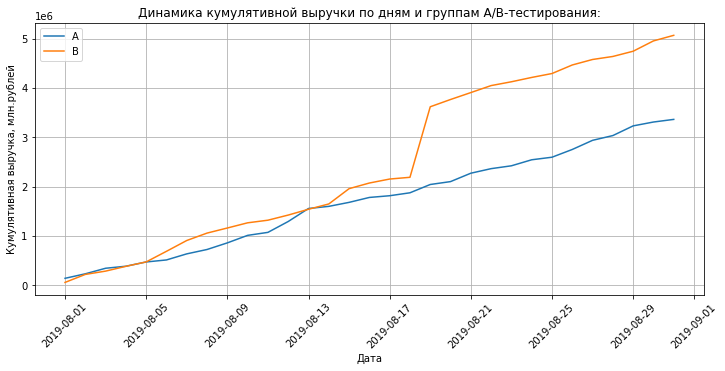

In [24]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# зафиксируем размер графиков
plt.rcParams["figure.figsize"] = (12,5)

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.title('Динамика кумулятивной выручки по дням и группам A/B-тестирования:')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка, млн.рублей')
plt.grid()
plt.xticks(rotation=45)
plt.legend();

Выручка увеличивается в течение всего теста. По группе А плавно и равномерно, а по группе В в определённой точке наблюдается резкий скачок. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. Возможно, это выбросы, их проанализируем позднее.

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:

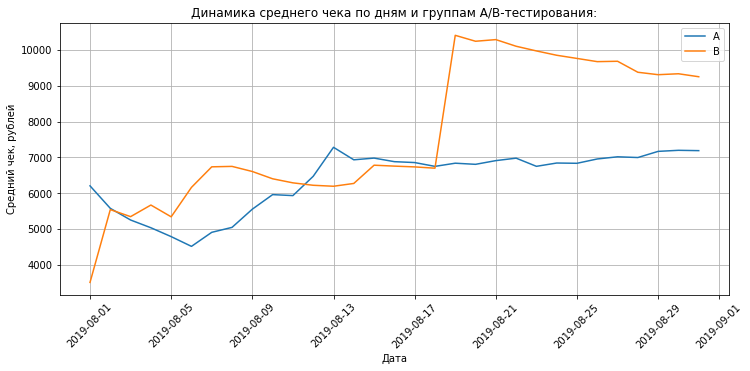

In [25]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('Динамика среднего чека по дням и группам A/B-тестирования:')
plt.xlabel('Дата')
plt.ylabel('Средний чек, рублей')
plt.grid()
plt.xticks(rotation=45)
plt.legend();

Средний чек становится равномерным ближе к концу теста в обеих группах. В группе В снова можно заметить резкий всплеск. Вероятно, в первой половине теста в эту группу попал крупный заказ. Таким образом, группе В нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

Построим график относительного различия для среднего чека. Добавим горизонтальную ось методом axhline() (от англ. horizontal line across the axis, «горизонтальная линия поперек оси»):

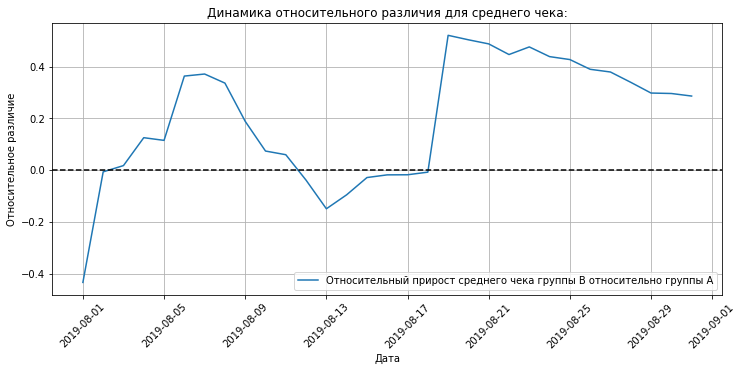

In [26]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(
    cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/
                                           mergedCumulativeRevenue['ordersB'])/
         (mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1,
         label="Относительный прирост среднего чека группы B относительно группы A")

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.grid()
plt.title('Динамика относительного различия для среднего чека:')
plt.xlabel('Дата')
plt.ylabel('Относительное различие')
plt.xticks(rotation=45);

В нескольких точках график различия между сегментами имеет резкие скачки. Причина наверняка кроется в крупных заказах и выбросах, изучим их позже.

Аналогично проанализируем график кумулятивной конверсии:

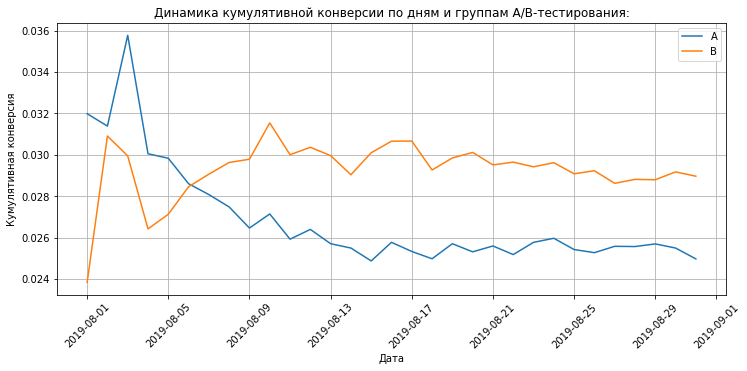

In [27]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.title('Динамика кумулятивной конверсии по дням и группам A/B-тестирования:')
plt.xlabel('Дата')
plt.ylabel('Кумулятивная конверсия')
plt.grid()
plt.xticks(rotation=45)
plt.legend();

В начале теста имелись резкие перепады конверсий в обеих группах, но затем конверсия группы В колебалась вокруг большего значения, чем конверсия группы А, которая, в свою очередь, просела и колебалась на более низком уровне.

Построим график относительного различия кумулятивных конверсий:

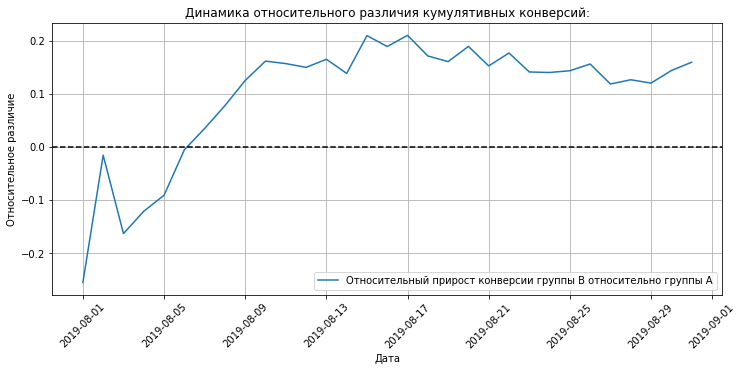

In [28]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(
    cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1,label="Относительный прирост конверсии группы B относительно группы A")

plt.axhline(y=0, color='black', linestyle='--')
plt.legend()
plt.grid()
plt.title('Динамика относительного различия кумулятивных конверсий:')
plt.xlabel('Дата')
plt.ylabel('Относительное различие')
plt.xticks(rotation=45);

В начале теста группа B проигрывала группе A, затем вырвалась вперёд. Далее отношение конверсии несолько колебалось, но до конца теста группа В лучше группы А.
В целом отношение конверсии могло ещё не установиться, и делать какие-либо выводы по тесту преждевременно. Таким образом, сначала стоит проанализировать аномалии, возможно, они изменят картину.

Мы провели анализ кумулятивных метрик по каждой группе А/В-теста.  
Кумулятивная выручка увеличивается в течение всего теста. По группе А плавно и равномерно, а по группе В в определённой точке наблюдается резкий скачок. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке.  
Средний чек становится равномерным ближе к концу теста в обеих группах. В группе В снова можно заметить резкий всплеск. Вероятно, в первой половине теста в эту группу попал крупный заказ. Таким образом, группе В нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.  
График относительного различия для среднего чека между группами А и В имеет резкие скачки. Причина наверняка кроется в крупных заказах и выбросах.  
Изучив динамику кумулятивной конверсии, мы заметили в начале теста резкие перепады в обеих группах, но затем конверсия группы В колебалась вокруг большего значения, чем конверсия группы А, которая, в свою очередь, просела и колебалась на более низком уровне.  
Относительный прирост конверсии группы B относительно группы A во второй половине теста имел положительное значение, что делает группу В более привлекательной. Однако, в целом отношение конверсии могло ещё не установиться, и делать какие-либо выводы по тесту на текущем этапе рано. Таким образом, мы переходим к анализу выбросов и всплесков.

 <a id='anchor_5'></a>
## Анализ выбросов и всплесков

Наличие аномальных значений в выборке может сильно исказить результат проведенного А/В-теста, ведь если такой дорогой заказ попадёт в одну из групп теста, он сразу же сделает победителем ту группу, где оказался. При этом такие покупки — редкость, исключение, которое проявилось не из-за тестирования гипотезы, а случайно. Таким образом, необходимо изучить наши данные на предмет наличия в них выбросов. 

Посчитаем, сколько заказов осуществлял каждый пользователь в нашем интернет-магазине. Вряд ли средний пользователь делает много заказов в одном магазине за короткий срок. Выполним группировку, отсортируем в порядке убывания количесва заказов и определим лидеров:

In [29]:
ordersByUsers = (
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': 'nunique'})
)

ordersByUsers.columns = ['user_id', 'orders']

ordersByUsers.sort_values(by='orders', ascending=False).head(10)

,user_id,orders
908,3967698036,3
55,249864742,3
478,2108163459,3
687,2988190573,3
890,3908431265,3
138,611059232,3
632,2742574263,3
157,678354126,2
323,1404560065,2
452,1985475298,2


Есть пользователи, которые совершали 2 и 3 заказа. Однако, чем обычный средний пользователь редко делает в течение месяца больше одного заказа. Построим точечную диаграмму числа заказов на одного пользователя:

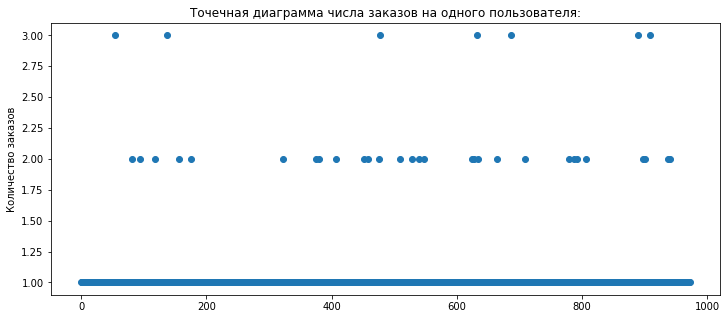

In [30]:
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечная диаграмма числа заказов на одного пользователя:')
plt.ylabel('Количество заказов');

Выводы подтверждаются: большинство пользователей делали 1 заказ. Доля пользователей с числом заказов от двух не ясна — непонятно, считать их аномалиями или нет.
Посчитаем выборочные перцентили количества заказов на одного пользователя:

In [31]:
percentile_orders = np.percentile(ordersByUsers['orders'], 99)
np.percentile(ordersByUsers['orders'], [90, 95, 99])

array([1., 1., 2.])

Получается, что только 1% пользователей в изучаемый месяц делал 2 и более заказов. Их смело можно отсечь, не нанеся при этом урон исследованию.

При проведении А/В-теста исказить результаты может не только большое количество заказов, совершённое одним пользователем, но и крупная сумма заказа, поэтому построим точечный график стоимостей заказов:

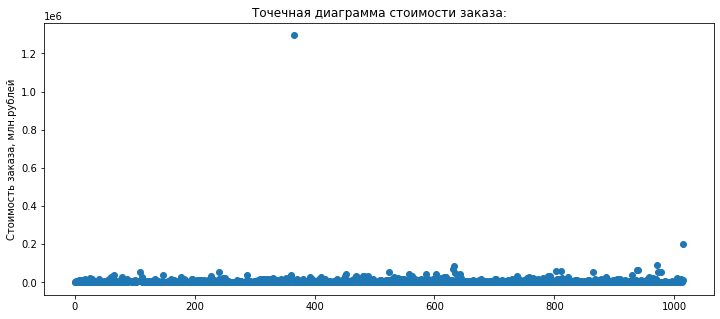

In [32]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.title('Точечная диаграмма стоимости заказа:')
plt.ylabel('Стоимость заказа, млн.рублей');

Действительно, заказ на сумму более 1.2 млн.рублей вряд ли можно назвать типичным. Впрочем суммы от 100 тыс.рублей тоже достаточно редки. Тем не менее, принято отсеивать не более 5% наблюдений, поэтому снова посмотрим выборочные перцентили стоимости заказа:

In [33]:
percentile_revenue = np.percentile(orders['revenue'], 99)
np.percentile(orders['revenue'], [90, 95, 99])

array([17990., 26785., 53904.])

Не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Так как отсекать мы будем по двум факторам, границу для определиния выбросов будем брать по 1%-ному перцентилю, чтобы в общей сложности не отбросить слишком большое количество значений.

Таким образом, мы определились с границами отсечения аномалий и можем переходить к следующему этапу исследования.

 <a id='anchor_6'></a>
 ## Анализ А/В-теста

На предыдущих этапах исследования мы:

- Оценили результаты A/B-теста визуально и выяснили, что в данных, скорее всего, есть выбросы;
- Увидели выбросы и нашли границу для их определения.

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей, затем по «очищенным». Полученные результаты сравним и сделаем выводы.

 <a id='anchor_7'></a>
### Статистическая значимость различий в конверсии между группами по «сырым» данным

Начнём с определения статистической значимости различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.  
**Сформулируем гипотезы.**   
*Нулевая:* статистически значимых различий в конверсии между группами нет.  
*Альтернативная:* различия в конверсии между группами статистически значимы.

Начнём с подготовки данных. Выделим информацию по каждой группе в отдельные столбцы, добавим кумулятивные метрики:

In [34]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

data.head()

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,23,142779,17,59758,23,142779,17,59758,719,713,719,713
1,2019-08-02,19,91602,23,162043,42,234381,40,221801,619,581,1338,1294
2,2019-08-03,24,112473,14,67049,66,346854,54,288850,507,509,1845,1803
3,2019-08-04,11,41176,14,96890,77,388030,68,385740,717,770,2562,2573
4,2019-08-05,22,86383,21,89908,99,474413,89,475648,756,707,3318,3280


В результате у нас получилась таблица со следующими столбцами:

- date — дата;
- ordersPerDateA — количество заказов в выбранную дату в группе A;
- revenuePerDateA — суммарная выручка в выбранную дату в группе A;
- ordersPerDateB — количество заказов в выбранную дату в группе B;
- revenuePerDateB — суммарная выручка в выбранную дату в группе B;
- ordersCummulativeA — суммарное число заказов до выбранной даты включительно в группе A;
- revenueCummulativeA — суммарная выручка до выбранной даты включительно в группе A;
- ordersCummulativeB — суммарное количество заказов до выбранной даты включительно в группе B;
- revenueCummulativeB — суммарная выручка до выбранной даты включительно в группе B;
- visitorsPerDateA — количество пользователей в выбранную дату в группе A;
- visitorsPerDateB — количество пользователей в выбранную дату в группе B;
- visitorsCummulativeA — количество пользователей до выбранной даты включительно в группе A;
- visitorsCummulativeB — количество пользователей до выбранной даты включительно в группе B.
    
Посчитаем статистическую значимость различия в конверсии между группами:

In [35]:
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('Cтатистическая значимость различия в конверсии между группами:', "{0:.3f}".format(stats.mannwhitneyu(
    sampleA, sampleB)[1]))

print('Относительный прирост конверсии группы B:', "{0:.3f}".format(
    sampleB.mean() / sampleA.mean() - 1))

Cтатистическая значимость различия в конверсии между группами: 0.011
Относительный прирост конверсии группы B: 0.160


**Вывод:** по «сырым» данным различия в конверсии групп A и B статистически значимы.  
Первое число — p-value = 0.011 меньше 0.05 (выбранный нами уровень статистической значимости). Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, можно отвергнуть в пользу альтернативной гипотезы. Относительный выйгрыш группы B равен 16.0% — второе число в выводе.

 <a id='anchor_8'></a>
 ### Статистическая значимость различий в среднем чеке заказа между группами по «сырым» данным

Теперь проверим статистическую значимость различий в среднем чеке между группами А и В.  
**Сформулируем гипотезы.**  
*Нулевая:* статистически значимых различий в среднем чеке между группами нет.  
*Альтернативная:* различия в среднем чеке между группами статистически значимы.  
Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию mannwhitneyu() данные о выручке с заказов.
А также найдём относительные различия в среднем чеке между группами:

In [36]:
print('Cтатистическая значимость различия в среднем чеке между группами:', '{0:.3f}'.format(stats.mannwhitneyu(orders[
    orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительный прирост среднего чека группы B:', '{0:.3f}'.format(orders[orders['group']=='B'][
    'revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

Cтатистическая значимость различия в среднем чеке между группами: 0.829
Относительный прирост среднего чека группы B: 0.287


**Вывод:** по «сырым» данным статистически значимых различий в среднем чеке между группами нет.
В результате мы получили p-value = 0.829, что гораздо больше 0.05 (выбранный нами уровень статистической значимости). Таким образом, мы можем принять нулевую гипотезу об отсутствии статистически значимых различий в среднем чеке между группами. Однако, относительный прирост среднего чека группы B составил 28.7%. Вероятнее всего, данная разница обусловлена как раз наличием выбросов в одной из групп.  
«Очистим» данные и сравним результаты.

 <a id='anchor_9'></a>
 ### Статистическая значимость различий в конверсии между группами по «очищенным» данным

Ранее мы уже определили 95-й и 99-й перцентили средних чеков, которые равны 26 785 и 53 904 рублям соответственно (ранее сохранили в переменой percentile_revenue). А 99-й перцентиль количества заказов на одного пользователя равен 2 заказам на пользователя (переменная percentile_orders).
Примем за аномальных пользователей тех, кто совершил от percentile_orders заказов или совершил заказ дороже percentile_revenue. Так мы уберём 1% пользователей с наибольшим числом заказов и 1% пользователей с дорогими заказами. Сделаем срезы пользователей с большим числом заказов — usersWithManyOrders и пользователей, совершивших дорогие заказы — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.
Узнаем, сколько всего аномальных пользователей методом shape():

In [37]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > percentile_orders]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > percentile_orders]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > percentile_revenue]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
display(abnormalUsers.head(5))
abnormalUsers.shape

1099    148427295
33      249864742
58      611059232
949     887908475
744     888512513
dtype: int64

(16,)

Всего 16 аномальных пользователей.

Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в конверсии между группами теста по "очищенным" данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

In [38]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

**Сформулируем гипотезы.**   
*Нулевая:* статистически значимых различий в конверсии между группами нет.  
*Альтернативная:* различия в конверсии между группами статистически значимы.

Применим статистический критерий Манна-Уитни к полученным выборкам с исключенными выбросами:

In [39]:
print('Cтатистическая значимость различия в конверсии между группами:', '{0:.3f}'.format(
    stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост конверсии группы B:', '{0:.3f}'.format(
    sampleBFiltered.mean()/sampleAFiltered.mean()-1))

Cтатистическая значимость различия в конверсии между группами: 0.007
Относительный прирост конверсии группы B: 0.189


**Вывод:** по «очищенным» данным различия в конверсии групп A и B снова статистически значимы.  
Первое число — p-value = 0.007 меньше 0.05 (выбранный нами уровень статистической значимости). Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, можно отвергнуть в пользу альтернативной гипотезы. Относительный выйгрыш группы B равен 18.9% — второе число в выводе (что немного больше в сравнении с первоначальным массивом,  содержащим выбросы).

 <a id='anchor_10'></a>
 ### Статистическая значимость различий в среднем чеке заказа между группами по «очищенным» данным

Проверим, произошли ли изменения с результами по среднему чеку.  
**Сформулируем гипотезы.**  
*Нулевая:* статистически значимых различий в среднем чеке между группами нет.  
*Альтернативная:* различия в среднем чеке между группами статистически значимы.  

In [40]:
print(
    'Cтатистическая значимость различия в среднем чеке между группами:', '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    'Относительный прирост среднего чека группы B:', "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

Cтатистическая значимость различия в среднем чеке между группами: 0.788
Относительный прирост среднего чека группы B: -0.032


**Вывод:** по «очищенным» данным статистически значимых различий в среднем чеке между группами нет.  
В результате мы получили p-value = 0.788, что гораздо больше 0.05 (выбранный нами уровень статистической значимости). Таким образом, мы можем принять нулевую гипотезу об отсутствии статистически значимых различий в среднем чеке между группами. Однако, относительный прирост среднего чека группы B сильно изменился с удалением выбросов составил только 3.2% (со знаком минус). Таким образом, мы убедились в предположении, что наличие аномальных значений в выборках сильно искажали результаты теста (несмотря на то, что общие выводы по результатам теста не изменились).

Таким образом, по результату А/В-теста мы можем сделать следующие выводы:

1) Различия по конверсии между группами статистически значимы как по «сырым», так и по данным после фильтрации аномалий;  
2) Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Однако, относительный прирост среднего чека группы В над группой А сильно снижается с удалением выбросов (по «сырым» данным составлял почти 29%, по «очищенным» чуть больше 3%, причем с противоположным знаком);  
3) График различия конверсии между группами сообщает, что результаты группы B во второй половине теста становятся стабильно лучше группы A;  
4) График различия среднего чека не даёт оснований делать выводы о преимуществе какой-либо из групп, в чём мы и убедились устранив из выборок тестирования выбросы - статистически значимых различий по среднему чеку не обнаружено и относительное изменение между ними незначительно.
    
Тест следует остановить и признать его успешным. Полученные в результате теста выводы дают основания считать, что пользователи из группы В стабильно лучше конвертируются, что положительно скажется на объёмах продаж даже при условии неизменности размера среднего чека.

 <a id='anchor_11'></a>
## Общий вывод по исследованию

Мы изучили исходные данные, убедились в отсутствии пропусков и дубликатов, привели тип данных к более подходящему для работы (в частности, информацию о датах). Обнаружили в группах пересекающиеся значения (58 пользователей) и удалили их.  
Закончив с предобработкой данных, мы перешли к следующим шагам исследования.

Изучили 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами Reach, Impact, Confidence, Effort. Мы применили фреймворки ICE и RICE для приоритизации гипотез. Результаты несколько отличаются при подключении фактора охвата пользователей. Наиболее перспективной для проверки оказалась гипотеза: добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок (без учета охвата занимала третье место в приоритете). Именно здесь мы получаем наибольший охват пользователей при наименьших затратах ресурсов на проверку гипотезы и наибольшей уверенности в этих гипотезах с наибольшим влиянием на пользователей. Эта гипотеза получила лидирующие позиции приоритета при оценке как силы гипотезы, так и количества охваченных пользователей.

Далее мы провели анализ кумулятивных метрик по каждой группе А/В-теста.  
Кумулятивная выручка увеличивалась в течение всего теста. По группе А плавно и равномерно, а по группе В в определённой точке наблюдался резкий скачок. Средний чек становился равномерным ближе к концу теста в обеих группах. В группе В снова был замечен резкий всплеск.  
График относительного различия для среднего чека между группами А и В также содержал резкие скачки. Причина наверняка кроется в крупных заказах и выбросах.  
Изучив динамику кумулятивной конверсии, мы заметили в начале теста резкие перепады в обеих группах, но затем конверсия группы В колебалась вокруг большего значения, чем конверсия группы А, которая, в свою очередь, просела и колебалась на более низком уровне.  
Относительный прирост конверсии группы B относительно группы A во второй половине теста имел положительное значение, что делает группу В более привлекательной. Однако, в целом отношение конверсии могло ещё не установиться, и делать какие-либо выводы по тесту на текущем этапе рано. Таким образом, мы перешли к анализу выбросов и всплесков.

Наличие аномальных значений в выборке может сильно исказить результат проведенного А/В-теста, ведь если такой дорогой заказ попадёт в одну из групп теста, он сразу же сделает победителем ту группу, где оказался. При этом такие покупки — редкость, исключение, которое проявилось не из-за тестирования гипотезы, а случайно. 

Мы выяснили, что не более 5% заказов дороже 26 785 рублей и не более 1% дороже 53 904 рублей. Только 1% пользователей делают 2 и более заказов в месяц. Так как отсечение мы делали по двум факторам, границу для определиния выбросов определили по 1%-ному перцентилю, чтобы в общей сложности не отбросить слишком большое количество значений.

Посчитали статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей, затем по «очищенным».  

По «сырым» данным различия в конверсии групп A и B статистически значимы.  
Первое число — p-value = 0.011 меньше 0.05 (выбранный нами уровень статистической значимости). Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, можно отвергнуть в пользу альтернативной гипотезы. Относительный выйгрыш группы B равен 16.0%.

По «сырым» данным статистически значимых различий в среднем чеке между группами нет.
В результате мы получили p-value = 0.829, что гораздо больше 0.05 (выбранный нами уровень статистической значимости). Таким образом, мы можем принять нулевую гипотезу об отсутствии статистически значимых различий в среднем чеке между группами. Однако, относительный прирост среднего чека группы B составил 28.7%. Вероятнее всего, данная разница обусловлена как раз наличием выбросов в одной из групп.  
«Очистили» данные и сравнили результаты.

По «очищенным» данным различия в конверсии групп A и B снова статистически значимы.  
Первое число — p-value = 0.007 меньше 0.05 (выбранный нами уровень статистической значимости). Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, можно отвергнуть в пользу альтернативной гипотезы. Относительный выйгрыш группы B равен 18.9% (что немного больше в сравнении с первоначальным массивом,  содержащим выбросы).

По «очищенным» данным статистически значимых различий в среднем чеке между группами нет.
В результате мы получили p-value = 0.788, что гораздо больше 0.05 (выбранный нами уровень статистической значимости). Соответственно, мы можем принять нулевую гипотезу об отсутствии статистически значимых различий в среднем чеке между группами. Однако, относительный прирост среднего чека группы B сильно изменился с удалением выбросов составил только 3.2% (со знаком минус). Мы убедились в предположении, что наличие аномальных значений в выборках сильно искажали результаты теста (несмотря на то, что общие выводы по результатам теста не изменились).

Таким образом, по результату А/В-теста мы можем сделать следующие выводы:

1) Различия по конверсии между группами статистически значимы как по «сырым», так и по данным после фильтрации аномалий;  
2) Нет статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий. Однако, относительный прирост среднего чека группы В над группой А сильно снижается с удалением выбросов (по «сырым» данным составлял почти 29%, по «очищенным» чуть больше 3%, причем с противоположным знаком);  
3) График различия конверсии между группами демонстрируетет, что результаты группы B во второй половине теста становятся стабильно лучше группы A;  
4) График различия среднего чека не даёт оснований делать выводы о преимуществе какой-либо из групп, в чём мы и убедились устранив из выборок тестирования выбросы - статистически значимых различий по среднему чеку не обнаружено и относительное изменение между ними незначительно.
    
Тест следует остановить и признать его успешным. Полученные в результате теста выводы дают основания считать, что пользователи из группы В стабильно лучше конвертируются, что положительно скажется на объёмах продаж даже при условии неизменности размера среднего чека.